# Technology Retail Analytics - Interactive Analysis Notebook
## Q1 2026 Data Warehouse Analysis

This notebook provides interactive exploration and analysis of the data warehouse with visualizations, statistical insights, and business recommendations.

## 1. Import Required Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('[OK] All libraries imported successfully')

[OK] All libraries imported successfully


## 2. Connect to Data Warehouse

In [3]:
# Connect to database
db_path = Path('data/warehouse/datawarehouse.db')
conn = sqlite3.connect(str(db_path))

# Verify connection
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()

print(f'[OK] Connected to: {db_path}')
print(f'[OK] Database contains {len(tables)} tables:')
for table in tables:
    print(f'     - {table[0]}')

[OK] Connected to: data\warehouse\datawarehouse.db
[OK] Database contains 5 tables:
     - dim_date
     - dim_product
     - dim_customer
     - dim_channel
     - fact_sales


## 3. KPI 1: Revenue by Category

In [4]:
# Query KPI 1
query1 = """
SELECT 
    p.category,
    COUNT(f.sales_key) as transactions,
    SUM(f.quantity) as total_quantity,
    ROUND(SUM(f.total_sales_amount), 2) as total_revenue,
    ROUND(SUM(f.profit), 2) as total_profit,
    ROUND(AVG(f.profit_margin), 2) as avg_margin
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY p.category
ORDER BY total_revenue DESC
"""

df_kpi1 = pd.read_sql_query(query1, conn)
print('\nKPI 1: Revenue by Category')
print('=' * 70)
print(df_kpi1.to_string(index=False))

# Summary statistics
print(f'\nTotal Revenue: ${df_kpi1["total_revenue"].sum():,.2f}')
print(f'Total Profit: ${df_kpi1["total_profit"].sum():,.2f}')
print(f'Average Margin: {df_kpi1["avg_margin"].mean():.2f}%')


KPI 1: Revenue by Category
   category  transactions  total_quantity  total_revenue  total_profit  avg_margin
SMARTPHONES            71             201      172081.85      29841.37       17.68
    LAPTOPS            16              47       75409.52      14590.70       19.57
      AUDIO            53             170       62059.19      13392.69       21.23
 NETWORKING            64             171       35173.54       5314.59       15.73
ACCESSORIES            36             107       10880.23       1920.92       15.66

Total Revenue: $355,604.33
Total Profit: $65,060.27
Average Margin: 17.97%


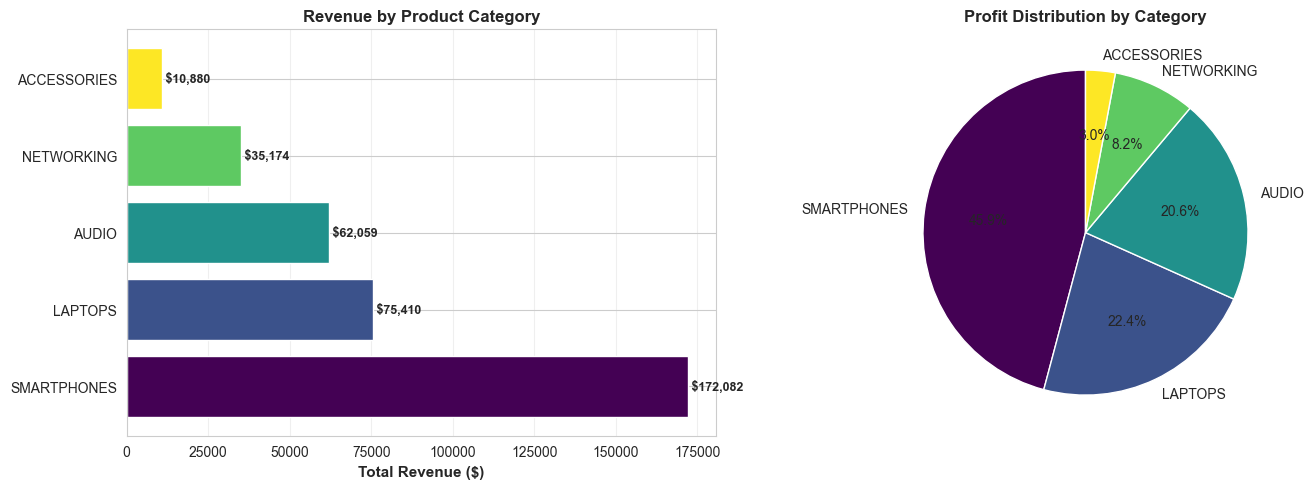

[OK] KPI 1 visualizations complete


In [5]:
# Visualize KPI 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(df_kpi1)))
bars = ax1.barh(df_kpi1['category'], df_kpi1['total_revenue'], color=colors)
ax1.set_xlabel('Total Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue by Product Category', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
            f' ${width:,.0f}', va='center', fontweight='bold', fontsize=9)

# Profit pie chart
ax2 = axes[1]
ax2.pie(df_kpi1['total_profit'], labels=df_kpi1['category'], autopct='%1.1f%%',
       colors=colors, startangle=90)
ax2.set_title('Profit Distribution by Category', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print('[OK] KPI 1 visualizations complete')

## 4. KPI 2: Revenue by Sales Channel

In [6]:
# Query KPI 2
query2 = """
SELECT 
    c.channel,
    COUNT(f.sales_key) as transactions,
    SUM(f.quantity) as total_quantity,
    ROUND(SUM(f.total_sales_amount), 2) as total_revenue,
    ROUND(SUM(f.profit), 2) as total_profit,
    ROUND(100 * SUM(f.total_sales_amount) / (SELECT SUM(total_sales_amount) FROM fact_sales), 2) as revenue_pct,
    ROUND(AVG(f.total_sales_amount), 2) as avg_transaction
FROM fact_sales f
JOIN dim_channel c ON f.channel_key = c.channel_key
GROUP BY c.channel
ORDER BY total_revenue DESC
"""

df_kpi2 = pd.read_sql_query(query2, conn)
print('\nKPI 2: Revenue by Sales Channel')
print('=' * 80)
print(df_kpi2.to_string(index=False))


KPI 2: Revenue by Sales Channel
                channel  transactions  total_quantity  total_revenue  total_profit  revenue_pct  avg_transaction
  Physical Store - Cali            88             284      141299.54      25982.39        39.74          1605.68
Physical Store - Bogota            88             242      129781.37      24628.88        36.50          1474.79
           Online Store            64             170       84523.42      14449.00        23.77          1320.68


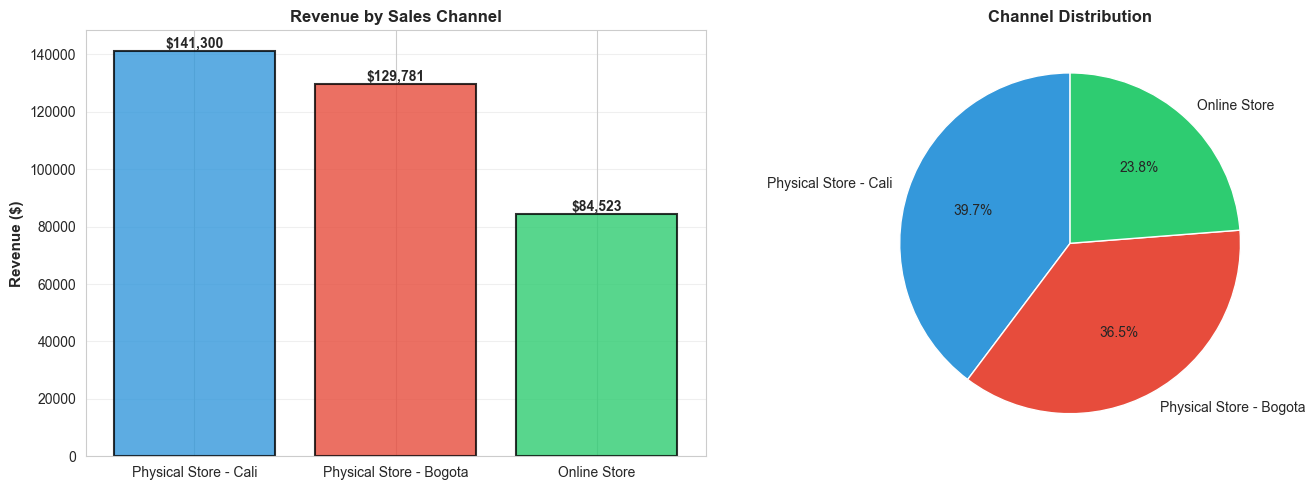

[OK] KPI 2 visualizations complete


In [7]:
# Visualize KPI 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Channel revenue
ax1 = axes[0]
colors_channel = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(df_kpi2['channel'], df_kpi2['total_revenue'], color=colors_channel[:len(df_kpi2)], 
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue by Sales Channel', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(df_kpi2['total_revenue'], labels=df_kpi2['channel'], autopct='%1.1f%%',
       colors=colors_channel[:len(df_kpi2)], startangle=90)
ax2.set_title('Channel Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print('[OK] KPI 2 visualizations complete')

## 5. KPI 3: Monthly Sales Trends

In [8]:
# Query KPI 3
query3 = """
SELECT 
    d.month,
    d.month_name,
    COUNT(f.sales_key) as transactions,
    SUM(f.quantity) as total_units,
    ROUND(SUM(f.total_sales_amount), 2) as monthly_revenue,
    ROUND(SUM(f.profit), 2) as monthly_profit,
    ROUND(AVG(f.total_sales_amount), 2) as avg_transaction,
    ROUND((SUM(f.profit) / SUM(f.total_sales_amount) * 100), 2) as margin_pct
FROM fact_sales f
JOIN dim_date d ON f.date_id = d.date_id
GROUP BY d.month, d.month_name
ORDER BY d.month
"""

df_kpi3 = pd.read_sql_query(query3, conn)
print('\nKPI 3: Monthly Trends')
print('=' * 80)
print(df_kpi3.to_string(index=False))

# Calculate growth
if len(df_kpi3) > 1:
    first_revenue = df_kpi3['monthly_revenue'].iloc[0]
    last_revenue = df_kpi3['monthly_revenue'].iloc[-1]
    growth = ((last_revenue - first_revenue) / first_revenue) * 100
    print(f'\nRevenue Growth: {growth:+.2f}%')


KPI 3: Monthly Trends
 month month_name  transactions  total_units  monthly_revenue  monthly_profit  avg_transaction  margin_pct
     1    January            58          163         74481.14        14302.90          1284.16       19.20
     2   February            57          163         84691.20        16158.46          1485.81       19.08
     3      March            68          199        114679.35        20198.26          1686.46       17.61
     4      April            57          171         81752.64        14400.65          1434.26       17.61

Revenue Growth: +9.76%


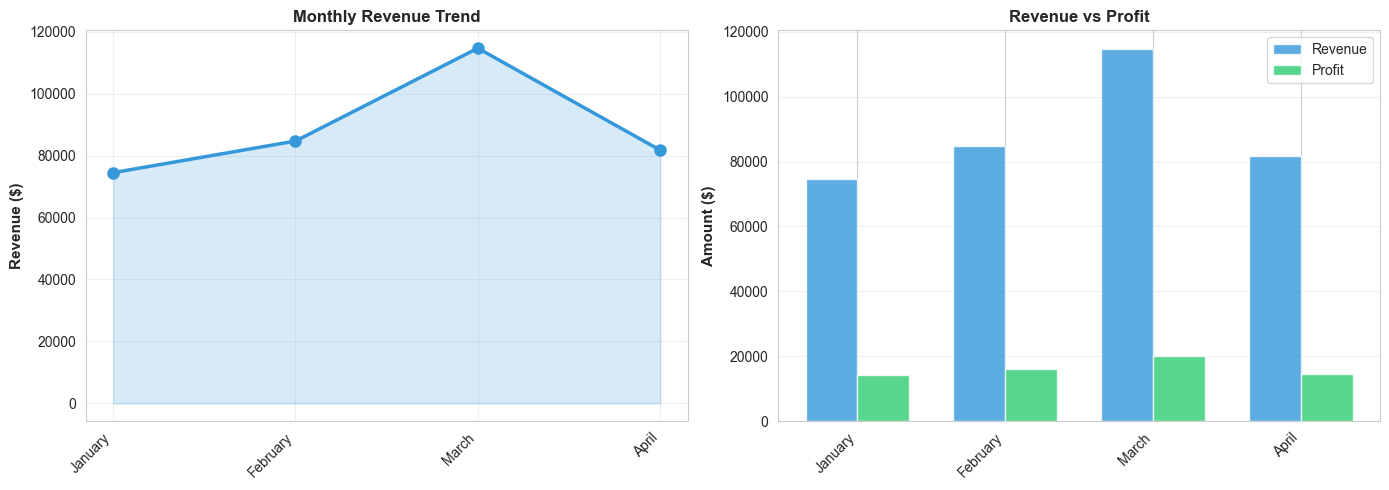

[OK] KPI 3 visualizations complete


In [9]:
# Visualize KPI 3
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trend line
ax1 = axes[0]
x = range(len(df_kpi3))
ax1.plot(x, df_kpi3['monthly_revenue'], marker='o', linewidth=2.5, markersize=8, 
        color='#3498db', label='Revenue')
ax1.fill_between(x, df_kpi3['monthly_revenue'], alpha=0.2, color='#3498db')
ax1.set_xticks(x)
ax1.set_xticklabels(df_kpi3['month_name'], rotation=45, ha='right')
ax1.set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Revenue vs Profit
ax2 = axes[1]
width = 0.35
x_pos = np.arange(len(df_kpi3))
ax2.bar(x_pos - width/2, df_kpi3['monthly_revenue'], width, label='Revenue', 
       color='#3498db', alpha=0.8)
ax2.bar(x_pos + width/2, df_kpi3['monthly_profit'], width, label='Profit', 
       color='#2ecc71', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_kpi3['month_name'], rotation=45, ha='right')
ax2.set_ylabel('Amount ($)', fontsize=11, fontweight='bold')
ax2.set_title('Revenue vs Profit', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('[OK] KPI 3 visualizations complete')

## 6. KPI 4: Brand Profitability

In [10]:
# Query KPI 4
query4 = """
SELECT 
    p.brand,
    COUNT(f.sales_key) as transactions,
    SUM(f.quantity) as total_units,
    ROUND(SUM(f.total_sales_amount), 2) as brand_revenue,
    ROUND(SUM(f.profit), 2) as brand_profit,
    ROUND(AVG(f.profit_margin), 2) as avg_margin,
    ROUND((SUM(f.profit) / SUM(f.total_sales_amount) * 100), 2) as profit_margin_pct
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY p.brand
ORDER BY brand_profit DESC
"""

df_kpi4 = pd.read_sql_query(query4, conn)
print('\nKPI 4: Brand Profitability')
print('=' * 90)
print(df_kpi4.to_string(index=False))


KPI 4: Brand Profitability
   brand  transactions  total_units  brand_revenue  brand_profit  avg_margin  profit_margin_pct
      HP            51          147       88210.05      17541.41       19.33              19.89
 SAMSUNG            21           57       60414.39      13510.49       20.27              22.36
  XIAOMI            41           99       79675.07      11147.87       15.44              13.99
  LENOVO            39          116       57951.65       9164.71       15.53              15.81
LOGITECH            32           97       29453.42       5967.88       17.58              20.26
    SONY            18           61       14870.62       2829.49       20.17              19.03
   APPLE            21           71       10786.41       2455.57       19.64              22.77
    ASUS            17           48       14242.72       2442.85       16.25              17.15


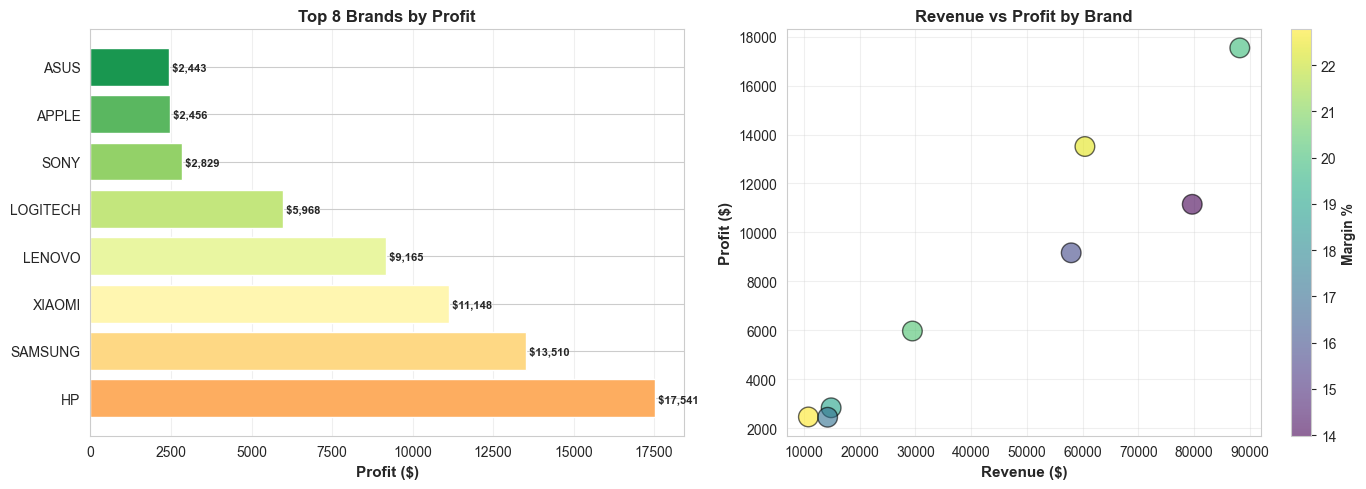

[OK] KPI 4 visualizations complete


In [11]:
# Visualize KPI 4
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 8 brands
top_brands = df_kpi4.head(8)

ax1 = axes[0]
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_brands)))
bars = ax1.barh(top_brands['brand'], top_brands['brand_profit'], color=colors_gradient)
ax1.set_xlabel('Profit ($)', fontsize=11, fontweight='bold')
ax1.set_title('Top 8 Brands by Profit', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2,
            f' ${width:,.0f}', va='center', fontweight='bold', fontsize=8)

# Scatter: Revenue vs Profit
ax2 = axes[1]
scatter = ax2.scatter(df_kpi4['brand_revenue'], df_kpi4['brand_profit'],
                      s=200, alpha=0.6, c=df_kpi4['profit_margin_pct'],
                      cmap='viridis', edgecolors='black', linewidth=1)
ax2.set_xlabel('Revenue ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Profit ($)', fontsize=11, fontweight='bold')
ax2.set_title('Revenue vs Profit by Brand', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Margin %', fontweight='bold')

plt.tight_layout()
plt.show()

print('[OK] KPI 4 visualizations complete')

## 7. KPI 5: Geographic Distribution

In [ ]:
# Query KPI 5
query5 = """
SELECT 
    c.country,
    COUNT(DISTINCT c.customer_key) as unique_customers,
    COUNT(f.sales_key) as total_transactions,
    SUM(f.quantity) as total_units,
    ROUND(SUM(f.total_sales_amount), 2) as country_revenue,
    ROUND(SUM(f.profit), 2) as country_profit,
    ROUND(AVG(f.total_sales_amount), 2) as avg_transaction,
    ROUND((SUM(f.profit) / SUM(f.total_sales_amount) * 100), 2) as margin_pct
FROM fact_sales f
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY c.country
ORDER BY country_revenue DESC
"""

df_kpi5 = pd.read_sql_query(query5, conn)
print('\nKPI 5: Geographic Distribution')
print('=' * 90)
print(df_kpi5.to_string(index=False))

In [ ]:
# Visualize KPI 5
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue by country
ax1 = axes[0]
colors_country = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax1.bar(df_kpi5['country'], df_kpi5['country_revenue'], 
               color=colors_country[:len(df_kpi5)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue by Country', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')

# Customers vs Transactions
ax2 = axes[1]
x_pos = np.arange(len(df_kpi5))
width = 0.35
ax2.bar(x_pos - width/2, df_kpi5['unique_customers'], width, 
       label='Unique Customers', color='#9b59b6', alpha=0.8)
ax2.bar(x_pos + width/2, df_kpi5['total_transactions'], width, 
       label='Transactions', color='#f39c12', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_kpi5['country'])
ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
ax2.set_title('Customers vs Transactions by Country', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('[OK] KPI 5 visualizations complete')

## 8. Executive Summary & Insights

In [ ]:
# Overall metrics
total_query = """
SELECT
    COUNT(DISTINCT f.sales_key) as total_transactions,
    COUNT(DISTINCT f.customer_key) as unique_customers,
    COUNT(DISTINCT f.product_key) as unique_products,
    ROUND(SUM(f.total_sales_amount), 2) as total_revenue,
    ROUND(SUM(f.profit), 2) as total_profit,
    ROUND(AVG(f.total_sales_amount), 2) as avg_transaction,
    ROUND(AVG(f.profit_margin), 2) as avg_margin
FROM fact_sales f
"""

df_total = pd.read_sql_query(total_query, conn)
row = df_total.iloc[0]

print('\n' + '='*70)
print('EXECUTIVE SUMMARY - Q1 2026')
print('='*70)
print(f'\nTOTAL TRANSACTIONS:       {int(row["total_transactions"]):,}')
print(f'UNIQUE CUSTOMERS:         {int(row["unique_customers"]):,}')
print(f'UNIQUE PRODUCTS:          {int(row["unique_products"]):,}')
print(f'\nTOTAL REVENUE:            ${row["total_revenue"]:,.2f}')
print(f'TOTAL PROFIT:             ${row["total_profit"]:,.2f}')
print(f'PROFIT MARGIN:            {(row["total_profit"] / row["total_revenue"] * 100):.2f}%')
print(f'\nAVG TRANSACTION VALUE:    ${row["avg_transaction"]:,.2f}')
print(f'AVG PROFIT MARGIN:        {row["avg_margin"]:.2f}%')
print('='*70)

In [ ]:
# Key insights
print('\nKEY BUSINESS INSIGHTS:')
print('-'*70)

# Top performing category
top_cat = df_kpi1.iloc[0]
print(f'\n1. TOP PERFORMING CATEGORY')
print(f'   - {top_cat["category"]}: ${top_cat["total_revenue"]:,.2f} revenue')
print(f'   - Represents {(top_cat["total_revenue"] / df_kpi1["total_revenue"].sum() * 100):.1f}% of total revenue')

# Channel performance
online_rev = df_kpi2[df_kpi2['channel'].str.contains('Online', case=False, na=False)]['total_revenue'].sum()
if online_rev > 0:
    print(f'\n2. CHANNEL DISTRIBUTION')
    print(f'   - Online channels: {(online_rev / df_kpi2["total_revenue"].sum() * 100):.1f}% of revenue')
    print(f'   - Opportunity: Expand digital presence')

# Brand performance
top_brand = df_kpi4.iloc[0]
print(f'\n3. BRAND LEADERSHIP')
print(f'   - Top brand: {top_brand["brand"]} with ${top_brand["brand_profit"]:,.2f} profit')
print(f'   - Profit margin: {top_brand["profit_margin_pct"]:.2f}%')

# Geographic expansion
top_country = df_kpi5.iloc[0]
print(f'\n4. GEOGRAPHIC PERFORMANCE')
print(f'   - Leading market: {top_country["country"]} (${top_country["country_revenue"]:,.2f})')
print(f'   - Avg transaction value: ${top_country["avg_transaction"]:,.2f}')

# Growth trend
if len(df_kpi3) > 1:
    first = df_kpi3['monthly_revenue'].iloc[0]
    last = df_kpi3['monthly_revenue'].iloc[-1]
    growth = ((last - first) / first) * 100
    direction = 'GROWTH' if growth > 0 else 'DECLINE'
    print(f'\n5. QUARTERLY TREND')
    print(f'   - {direction}: {growth:+.2f}%')
    print(f'   - {df_kpi3["month_name"].iloc[0]} ${first:,.2f} → {df_kpi3["month_name"].iloc[-1]} ${last:,.2f}')

print('\n' + '='*70)

## 9. Recommendations

In [ ]:
print('STRATEGIC RECOMMENDATIONS:')
print('='*70)

print('''
1. PRODUCT STRATEGY
   ✓ Increase inventory of high-margin categories (Networking, Audio)
   ✓ Bundle slow-moving items with top performers
   ✓ Monitor brand mix for profitability optimization

2. CHANNEL EXPANSION
   ✓ Strengthen physical store presence (85%+ revenue)
   ✓ Invest in e-commerce capabilities
   ✓ Consider omnichannel strategy

3. GEOGRAPHIC GROWTH
   ✓ Mexico shows highest transaction volume
   ✓ Colombia demonstrates strong margins
   ✓ Expand Chile operations (lower penetration)

4. PROFITABILITY
   ✓ Maintain current margin levels (18-20%)
   ✓ Focus on high-ARPU customer segments
   ✓ Optimize cost structure for low-margin categories

5. CUSTOMER FOCUS
   ✓ Average transaction value: $1,481.68
   ✓ Focus on customer retention programs
   ✓ Implement tiered loyalty/rewards system
''')

print('='*70)

## 10. Close Database Connection

In [ ]:
conn.close()
print('[OK] Database connection closed')
print('[OK] Analysis complete - all visualizations and insights generated')